In [8]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("..")

from llama_index.llms.openai import OpenAI
# from src.local_models.embeddings import get_embed_model
from llama_index.embeddings.openai import OpenAIEmbedding

from src.data_loader.load_files import load_data
from src.data_loader.chunking import chunk_docs_standalone

from src.data_loader.load_from_dir import rebuild_index

from src.nebula_graph.nebula_operations import show_hosts, add_hosts_if_not_available, show_spaces, init_nebula_cluster
from src.nebula_graph.text_2_graph import df_to_fig, extract_triplets, get_response_n_kg_rel_query, get_response_n_kg_rel_chat

#from llama_index.core import Document
import os, re, ast

from dotenv import load_dotenv

In [9]:
from llama_index.graph_stores.nebula import NebulaGraphStore
from llama_index.core import KnowledgeGraphIndex, VectorStoreIndex, SimpleDirectoryReader

from llama_index.core.response_synthesizers import get_response_synthesizer
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import PromptTemplate


In [10]:
load_dotenv(override=True)

True

In [11]:
embed_model = OpenAIEmbedding()
llm = OpenAI()

In [25]:
add_hosts_if_not_available()

In [26]:
space_name = "zelda"

init_nebula_cluster(space_name)

In [27]:
edge_types, rel_prop_names = ["relationship"], ["relationship"] # default, could be omit if create from an empty kg
tags = ["entity"]

graph_store = NebulaGraphStore(
    space_name=space_name,
    edge_types=edge_types,
    rel_prop_names=rel_prop_names,
    tags=tags,
)

In [28]:
#first-time build
documents = load_data(os.environ['data_path'])

In [29]:
len(documents)

35

In [38]:
kg_index = KnowledgeGraphIndex.from_documents(
    documents,
    max_triplets_per_chunk=10,
    space_name=space_name,
    edge_types=edge_types,
    rel_prop_names=rel_prop_names,
    tags=tags,
)

In [39]:
kg_index.storage_context.persist(persist_dir="../db_stores/kg_index")

In [40]:
kg_index = rebuild_index('../db_stores/kg_index')

In [41]:
kg_rag_query_engine = kg_index.as_query_engine(
    include_text=True,
    retriever_mode="hybrid",
    response_mode="tree_summarize",
)


In [59]:
response = kg_rag_query_engine.query("Tell me more about Zelda.")
#主角是谁
#告诉我关于主角的一些事情
#王国之泪的背景设定是什么
#告诉我关于劳鲁的一些事情


In [60]:
resp, kg_rel_texts = get_response_n_kg_rel_query(response)
kg_rel_texts

["['Zelda', 'Possesses', 'Sealing power']",
 "['Zelda', 'Is', 'Princess of hyrule']",
 "['Zelda', 'Disappears', 'Suddenly']",
 "['Zelda', 'Values', 'Inhabitants']",
 "['Zelda', 'Working', 'Tirelessly']",
 "['Zelda', 'Freed from', 'Mission']",
 "['Zelda', 'Sworn to', 'By mineru']",
 "['Zelda', 'Sacrifices', 'Herself']",
 "['Zelda', 'Seals', 'Calamity']",
 "['Zelda', 'Rules', 'Kingdom']",
 "['Zelda', 'Helps', 'Link']"]

In [61]:
extracted_triplets = extract_triplets(kg_rel_texts)
extracted_triplets

,e1,r,e2
0,Zelda,Helps,Link
1,Zelda,Freed from,Mission
2,Zelda,Seals,Calamity
3,Zelda,Values,Inhabitants
4,Zelda,Is,Princess of hyrule
5,Zelda,Working,Tirelessly
6,Zelda,Disappears,Suddenly
7,Zelda,Possesses,Sealing power
8,Zelda,Sworn to,By mineru
9,Zelda,Rules,Kingdom


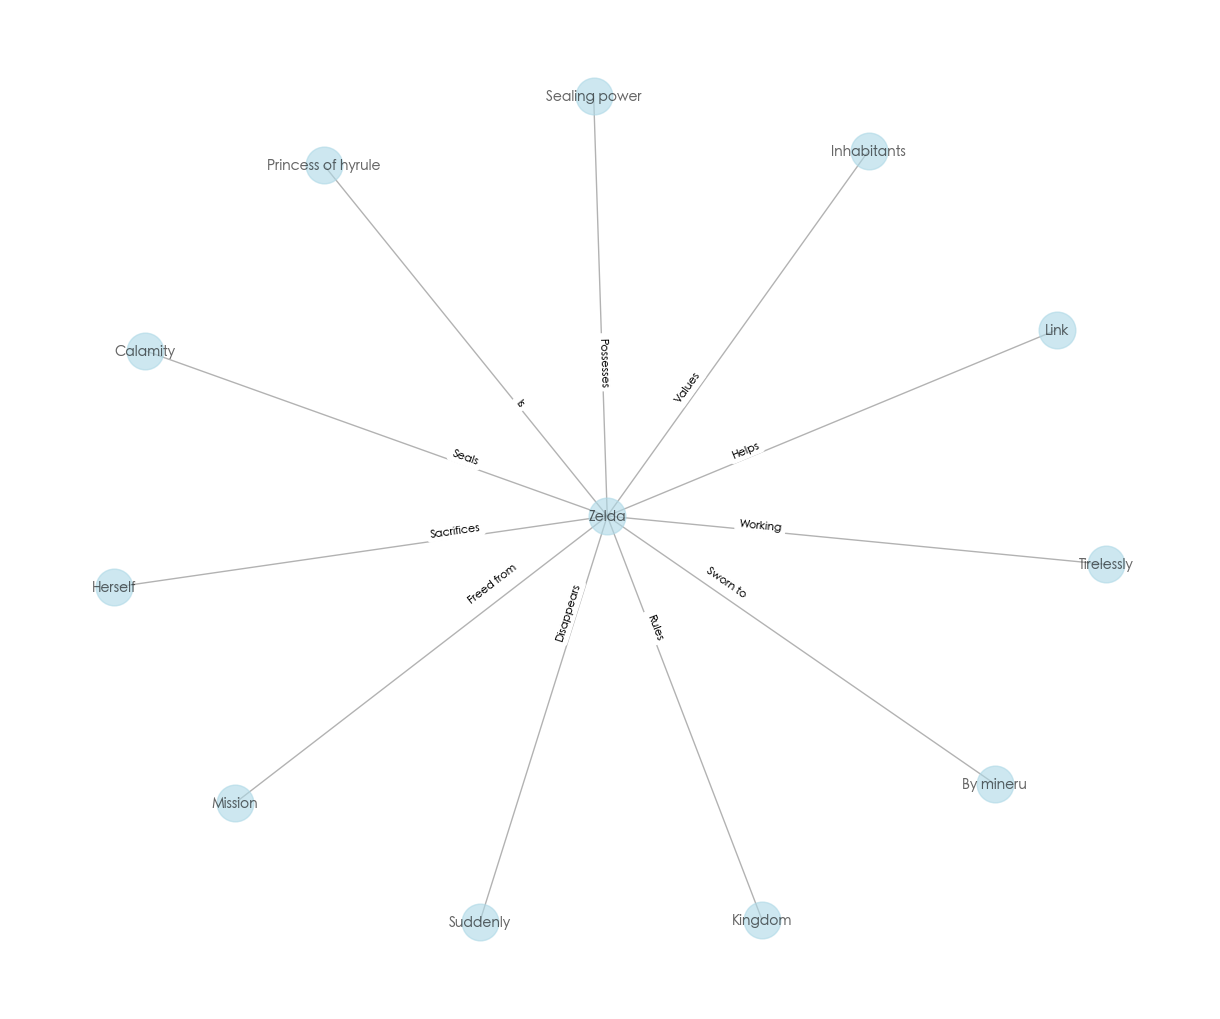

In [62]:
kg_fig = df_to_fig(extracted_triplets, show_fig=True)